In [266]:
from sklearn.feature_extraction.text import CountVectorizer
from category_encoders.one_hot import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from pandas.plotting import scatter_matrix
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

In [267]:
#Read cleaned csv file
violent = False

if violent:
    fname ='compas-scores-two-years-violent-cleaned.csv'
    decile_col = 'v_decile_score'
    score_col = 'v_score_text'
else:
    fname ='compas-scores-two-years-cleaned.csv'
    decile_col = 'decile_score'
    score_col = 'score_text'
    
df = pd.read_csv(fname)
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,score_text,v_type_of_assessment,v_decile_score,v_score_text,in_custody,out_custody,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,Risk of Violence,1,Low,2014-07-07,2014-07-14,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,Risk of Violence,1,Low,2013-01-26,2013-02-05,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,Low,Risk of Violence,3,Low,2013-06-16,2013-06-16,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,High,Risk of Violence,6,Medium,NaN,NaN,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,Low,Risk of Violence,1,Low,NaN,NaN,0,1102,0,0


In [268]:
#exploring columns
df.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment', 'score_text',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text', 'in_custody',
       'out_custody', 'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

ProPublicas reasoning for filter `raw_data`:
>However not all of the rows are useable for the first round of analysis.
>There are a number of reasons remove rows because of missing data:
>* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
>* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
>* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
>* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.*

In [269]:
# Filter rows as described by ProPublica
df = df[
        (df["days_b_screening_arrest"]<=30) & 
        (df["days_b_screening_arrest"]>=-30) &
        (df["is_recid"]!=-1) & 
        (df["c_charge_degree"]!="O") #&
        #(df["score_text"]!="N/A")
      ]

df.shape

(6172, 49)

In [270]:
df.age_cat.value_counts()

25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: age_cat, dtype: int64

In [271]:
df.race.value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [272]:
df.v_decile_score.value_counts()

1     1676
2      923
3      833
4      685
5      587
6      508
7      376
8      254
9      231
10      99
Name: v_decile_score, dtype: int64

In [273]:
df.decile_score.value_counts()

1     1286
2      822
4      666
3      647
5      582
6      529
7      496
9      420
8      420
10     304
Name: decile_score, dtype: int64

In [274]:
df.score_text.value_counts()

Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64

In [275]:
pd.crosstab(df.sex,df.race)

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,549,2,482,82,2,58
Male,2626,29,1621,427,9,285


<AxesSubplot:title={'center':"White Defendant's Decile Scores"}, ylabel='Frequency'>

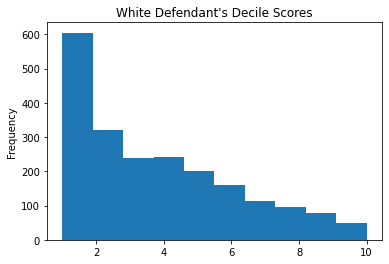

In [276]:
df[df.race=='Caucasian'][decile_col].plot(kind='hist',title="White Defendant's Decile Scores")

<AxesSubplot:title={'center':"Black Defendant's Decile Scores"}, ylabel='Frequency'>

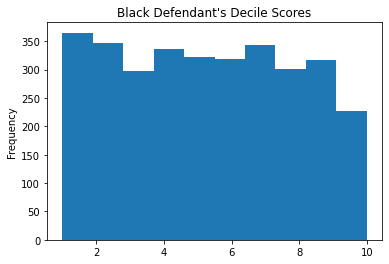

In [277]:
df[df.race=='African-American'][decile_col].plot(kind='hist',title="Black Defendant's Decile Scores")

In [278]:
recid_race=pd.crosstab(df.race,df.two_year_recid)
recid_race['rate'] = recid_race[1] / recid_race.sum(axis=1)
print(recid_race)

two_year_recid       0     1      rate
race                                  
African-American  1514  1661  0.523150
Asian               23     8  0.258065
Caucasian         1281   822  0.390870
Hispanic           320   189  0.371316
Native American      6     5  0.454545
Other              219   124  0.361516


In [279]:
recid_race=pd.crosstab(df.sex,df.two_year_recid)
recid_race['race']=recid_race[1]/recid_race.sum(axis=1)
print(recid_race)

two_year_recid     0     1      race
sex                                 
Female           762   413  0.351489
Male            2601  2396  0.479488


There are significant differences in recidivism in this population by race and gender.

In [280]:
score_race=pd.crosstab(df.race,df.score_text)
score_race['High risk rate']=score_race['High']/score_race.sum(axis=1)
print(score_race)

score_text        High   Low  Medium  High risk rate
race                                                
African-American   845  1346     984        0.266142
Asian                3    24       4        0.096774
Caucasian          223  1407     473        0.106039
Hispanic            47   368      94        0.092338
Native American      4     3       4        0.363636
Other               22   273      48        0.064140


In [281]:
score_sex=pd.crosstab(df.sex,df.score_text)
score_sex['High risk rate']=score_sex['High']/score_sex.sum(axis=1)
print(score_sex)

score_text  High   Low  Medium  High risk rate
sex                                           
Female       151   699     325        0.128511
Male         993  2722    1282        0.198719


****2. Predictive calibration and accuracy****

<AxesSubplot:xlabel='decile_score'>

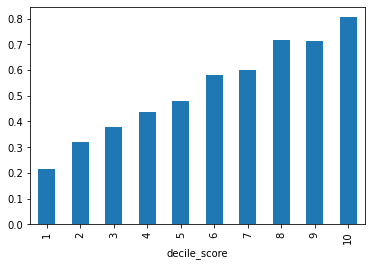

In [282]:
#probability of recidivism by decile
df.groupby(decile_col).mean()['two_year_recid'].plot(kind='bar')

<AxesSubplot:xlabel='decile_score'>

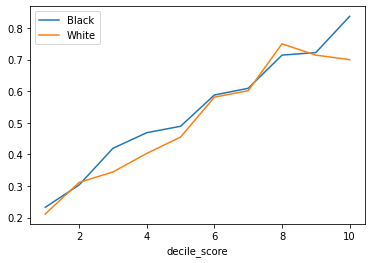

In [283]:
#probability of recidivism by decile and race
a = df[df.race=='African-American'].groupby([decile_col]).mean()['two_year_recid']
b = df[df.race=='Caucasian'].groupby([decile_col]).mean()['two_year_recid']

a = pd.concat([a,b],axis=1)
a.columns=['Black','White']
a.plot(kind='line')

splits "low" from "medium or high" risk

In [284]:
df['forecast_recid'] = df[score_col] != 'Low'
df['actual_recid'] = df['two_year_recid'] == 1
cm = pd.crosstab(df.actual_recid,df.forecast_recid)
print(cm)

forecast_recid  False  True
actual_recid               
False            2345  1018
True             1076  1733


Accuracy: the fraction of guesses that were correct.

Precision or Positive Predictive Value: of the people we guessed would recidivate, what fraction did?

False Positive Rate: of the people who didn't recidivate, how many did we guess would?

False Negative Rate: of the people who did recidivate, how many did we guess would not?

In [285]:
TN = cm[False][False]
TP = cm[True][True]
FN = cm[False][True]
FP = cm[True][False]

About 63% of those scored as medium or high risk end up getting arrested again within two years. This is the Positive Predictive Value (PPV) or Precision.

In [286]:
#PPV
TP / (TP + FP)

0.6299527444565612

Of those who did not go on to be re-arrested, about 30% were classified as medium or high risk. This is the False Positive Rate (FPR).

In [287]:
# FPR
FP / (FP + TN)

0.30270591733571217

In [288]:
P = TP + FN
N = TN + FP

In [289]:
# Equivalent definition of FPR that might be easier to understand, N in denominator
FP / N

0.30270591733571217

We can also calculate the False Negative Rate (FNR) which counts those who were classified as low risk, as a fraction of those who were re-arrested.

In [290]:
#FNR
FN / (FN+TP)

0.38305446778212887

In [291]:
#confusion matrix
def print_ppv_fpv(cm):
    # the indices here are [col][row] or [actual][guessed]
    TN = cm[False][False]   
    TP = cm[True][True]
    FN = cm[True][False]
    FP = cm[False][True]
    print('Accuracy: ', (TN+TP)/(TN+TP+FN+FP))
    print('PPV: ', TP / (TP + FP))
    print('FPR: ', FP / (FP + TN))
    print('FNR: ', FN / (FN + TP))
    print()
    
def print_metrics(guessed, actual):
    cm = pd.crosstab(guessed, actual, rownames=['guessed'], colnames=['actual'])
    print(cm)
    print()
    print_ppv_fpv(cm)    

In [292]:
print('White')
subset = df[df.race == "Caucasian"]
print_metrics(subset.forecast_recid, subset.actual_recid)

print('Black')
subset = df[df.race == "African-American"]
print_metrics(subset.forecast_recid, subset.actual_recid)

White
actual   False  True
guessed             
False      999   408
True       282   414

Accuracy:  0.6718972895863052
PPV:  0.5948275862068966
FPR:  0.22014051522248243
FNR:  0.49635036496350365

Black
actual   False  True
guessed             
False      873   473
True       641  1188

Accuracy:  0.6491338582677165
PPV:  0.6495352651722253
FPR:  0.4233817701453104
FNR:  0.2847682119205298



the False Positive Rate is substantially higher for black defendants.



****3. Decision tree to build own predictor****

Using these following predictors as dominant:
- Age
- Sex
_ c_charge_degree
- c_priors_count

In [293]:
#get dummies for age, race, gender
features = pd.concat([pd.get_dummies(df.age_cat,prefix='age',drop_first=True),
                    pd.get_dummies(df.sex, prefix='sex',drop_first=True),
                    pd.get_dummies(df.c_charge_degree, prefix='degree',drop_first=True), # felony or misdemeanor charge ('f' or 'm')
                    df.priors_count],
                    axis=1)

target = df.two_year_recid

In [294]:
x = features.values
y=target.values
dt = DecisionTreeClassifier()
dt.fit(x,y)

DecisionTreeClassifier()

In [295]:
# Examine regression coefficients
dt.score(x,y)

0.687297472456254

The model thinks that (for the non-violent data set):

being young (<25) more than doubles your odds of recidivism
but being >45 years old makes half as likely
being male increases your odds by 40%
every prior arrest increases your odds by 18%.

Now let's put our model through the same tests as we used on the COMPAS score to see how well this predictor does.



In [296]:
#crosstab for predictive model
y_pred = dt.predict(x)
guessed=pd.Series(y_pred)==1

actual=df.two_year_recid==1

cm = pd.crosstab(guessed, actual, rownames=['guessed'], colnames=['actual'])
cm

actual,False,True
guessed,,
False,1782,1529
True,1106,869


In [297]:
print_ppv_fpv(cm)

Accuracy:  0.5015134317063943
PPV:  0.44
FPR:  0.3829639889196676
FNR:  0.6376146788990825



In [298]:
print(df.race)

0                  Other
1       African-American
2       African-American
5                  Other
6              Caucasian
              ...       
7209    African-American
7210    African-American
7211               Other
7212    African-American
7213            Hispanic
Name: race, Length: 6172, dtype: object


In [299]:
#compare again between White and Black
print('White')
subset = df[df.race == "Caucasian"]
print_metrics(subset.forecast_recid, subset.actual_recid)

print('Black')
subset = df[df.race == "African-American"]
print_metrics(subset.forecast_recid, subset.actual_recid)

White
actual   False  True
guessed             
False      999   408
True       282   414

Accuracy:  0.6718972895863052
PPV:  0.5948275862068966
FPR:  0.22014051522248243
FNR:  0.49635036496350365

Black
actual   False  True
guessed             
False      873   473
True       641  1188

Accuracy:  0.6491338582677165
PPV:  0.6495352651722253
FPR:  0.4233817701453104
FNR:  0.2847682119205298

